In [5]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import torch, math

sns.set(font_scale=1.5, style="ticks")


In [6]:
df_res_seq = defaultdict(list)

for subtype in ("a_h3n2", ):
    for year in list(range(2014, 2020)):
        id2seq = dict()
        fasta_path = "../../data/gisaid/ha_processed/%d-08_to_%d-02_9999M/%s/human_minBinSize1_lenQuantile0.2.fasta" % (year-1, year, subtype)
        for record in SeqIO.parse(fasta_path, "fasta"):
            id2seq[record.id] = str(record.seq)

        # ground-truth
        gt_path = "/data/rsg/nlp/wenxian/esm/data/gisaid/flu/ha_processed/2003-10_to_2023-04_6M/%s/human_minBinSize100_lenQuantile0.2_bins/%d.fasta" % (subtype, (year-2018)*2+30)

        seq2freq = dict()
        cluster2freq = defaultdict(float)

        for record in SeqIO.parse(gt_path, "fasta"):
            desc = record.description.split()[1].strip().split("|")
            desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
            freq = float(desc["freq"])
            bin_size = float(desc["bin_size"])
            count = round(freq * bin_size)
            seq2freq[str(record.seq)] = freq

        model2path = [
            ("EVEscape", "../../runs/pipeline/%d-02/%s/vaccine_set=%d-02-%d-02___virus_set=last_6M/dominance_prediction/evescape/test_results.csv" % (year, subtype, year-3, year)),
            ("Last", "../../runs/pipeline/%d-02/%s/vaccine_set=%d-02-%d-02___virus_set=last_6M/dominance_prediction/history_6M/test_results.csv" % (year, subtype, year-3, year)),
            ("VaxSeer", "../../runs/pipeline/%d-02/%s/vaccine_set=%d-02-%d-02___virus_set=last_6M/dominance_prediction/weight_loss_by_count/lightning_logs/version_0/test_results.csv" % (year, subtype, year-3, year)),
        ]


        for model, path in model2path:
            df = pd.read_csv(path)

            seqid2loss = defaultdict(list) # dict(zip(df["src_id"], df[""]))
            for seq_id, prediction in zip(df["src_id"], df["prediction"]):
                seqid2loss[seq_id].append(prediction)
            seqid2logp = dict()
            for seq_id in seqid2loss:
                # logp
                seqid2logp[seq_id] = torch.logsumexp(-torch.tensor(seqid2loss[seq_id]),dim=0).item() - math.log(len(seqid2loss[seq_id]))

            # get topk seqs
            seq_and_logp = []
            for seq_id in seqid2logp:
                seq_and_logp.append((id2seq[seq_id], seqid2logp[seq_id]))
            seq_and_logp = sorted(seq_and_logp, key=lambda x: x[1], reverse=True)
            
            gtfreqs = []
            for seq,_ in seq_and_logp:
                gtfreqs.append(seq2freq.get(seq, 0.0))


            for percentile in range(0, 101, 5):
                if percentile == 0:
                    continue
                percentile = percentile / 100
                i = int(len(gtfreqs) * percentile)
                df_res_seq["topk"].append(percentile)
                df_res_seq["coverage"].append(sum(gtfreqs[:i]))
                df_res_seq["model"].append(model)
                df_res_seq["years"].append(year)
                df_res_seq["subtype"].append(subtype)
                
df_res_seq = pd.DataFrame(df_res_seq)


In [7]:
from scipy.interpolate import make_interp_spline

percentile=0.20

_data = df_res_seq[df_res_seq["topk"] == percentile]
new_data = defaultdict(list)

models_sort = list(set(_data["model"]))
models_sort.sort()
for model in models_sort:
    _data_model = _data[_data["model"] == model]

    x = _data_model["years"]
    y = _data_model["coverage"]

    X_Y_Spline = make_interp_spline(_data_model["years"], _data_model["coverage"],k=2)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)

    new_data["X"].extend(list(X_))
    new_data["Y"].extend(list(Y_))
    new_data["model"].extend([model]*len(X_))


new_data = pd.DataFrame(new_data)


5.410382350384729 3.937148180108077e-08
30.228091460942373 2.480296432530763e-143


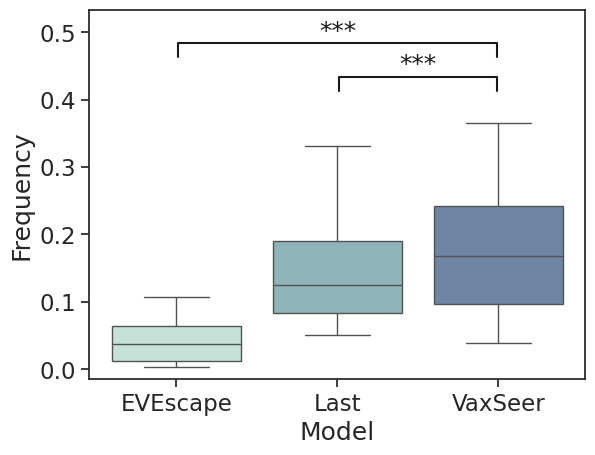

In [8]:
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=4).as_hex()
# print(list(palette))

ax = sns.boxplot(x=new_data["model"], y=new_data["Y"], hue=new_data["model"], 
                 palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=3),) # , palette="crest"

t_statistic, p_value1 = stats.ttest_ind(new_data[new_data["model"] == "VaxSeer"]["Y"], 
                                       new_data[new_data["model"] == "Last"]["Y"], alternative='greater')

print(t_statistic, p_value1)

t_statistic, p_value2 = stats.ttest_ind(new_data[new_data["model"] == "VaxSeer"]["Y"], 
                                       new_data[new_data["model"] == "EVEscape"]["Y"], alternative='greater')

print(t_statistic, p_value2)

# Define a function to annotate the plot
def annotate_significance(ax, x1, x2, y, p_value, y_offset=0.05):
    if p_value < 0.001:
        label = '***'
    elif p_value < 0.01:
        label = '**'
    elif p_value < 0.05:
        label = '*'
    else:
        label = 'ns'  # not significant

    ax.plot([x1+0.01, x1+0.01, x2-0.01, x2-0.01], [y + y_offset - 0.02, y + y_offset, y + y_offset, y + y_offset - 0.02], lw=1.5, c='k')
    ax.text((x1 + x2) * 0.5, y + y_offset, label, ha='center', va='bottom', color='k')


# Set y-limit higher to accommodate the annotation
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1] + 0.15])

# Add annotation
annotate_significance(ax, 1, 2, ylim[1], p_value1)
annotate_significance(ax, 0, 2, ylim[1], p_value2, 0.1)

ax.set_ylabel("Frequency")

ax.set_xlabel("Model")

plt.savefig("figs/frequency_percentile_%.2lf_%s_boxplot.pdf" % (percentile, subtype), format='pdf', bbox_inches='tight')